In [2]:
#!pip install pandas openpyxl geopandas matplotlib

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## DATACENTER WITH ID "3668" HAS INVERTED LATITUDE. IS 122, SHOULD BE -122

## Remember to find missing temperatures for hawaii, alaska and district of columbia

In [252]:
data = '../in/datacentermap copy.csv'

#dc_df = datacenter_dataframe
dc_df = pd.read_csv(data)

# Remove inplace=True
dc_df.drop(['postal', 'link_profile'], axis=1, inplace=True)

mainCountry = 'USA'

mask = dc_df['country'] == mainCountry

dc_df = dc_df[mask]

# Create a GeoDataFrame
dc_gdf = gpd.GeoDataFrame(dc_df, geometry=gpd.points_from_xy(dc_df.longitude, dc_df.latitude))

# Define or identify the coordinate reference system (CRS)
# For the United States, you can use EPSG:4326 (WGS 84) which is commonly used for latitude and longitude coordinates
dc_gdf.crs = "EPSG:4326"

# Loading custom us state shapefile
states_map = gpd.read_file('../in/States_shapefile-shp/States_shapefile.shp')

In [253]:
power_df = pd.read_excel('../in/avgprice_annual.xlsx', skiprows=1)

#only keeping power prices from 2020
power_df = power_df[power_df['Year'] == 2020]

#only keeping "total electric industry" as the industry sector as its the only one that has all 51 states.
power_df = power_df[power_df['Industry Sector Category'] == 'Total Electric Industry']


In [276]:
def plot_us_states(gdf, data_column, plot_points=None, title='INSERT TITLE', colormap='RdYlGn'):
    fig = plt.figure(figsize=(20, 13))
    fig.suptitle(title, fontsize=24)
    
    # Exclude Hawaii and Alaska when making the initial mainland/contiguous plot
    mainland_us = gdf[~gdf['State_Name'].isin(['HAWAII', 'ALASKA'])]
    # Make new geodataframes for each of the excluded states
    alaska = gdf[gdf['State_Name'] == 'ALASKA']
    hawaii = gdf[gdf['State_Name'] == 'HAWAII']

    # Create a new axis for mainland US
    ax_mainland = fig.add_axes([0, 0.05, 1, 1])  # [x, y, width, height]
    # Plot mainland US. States with kissing values ("missing_kwds") get colored gray.
    mainland_us.plot(column=data_column, cmap=colormap, linewidth=0.8, ax=ax_mainland, edgecolor='0.5', legend=False, missing_kwds={'color': 'lightgrey'})
    
    # Add Alaska Axis (x, y, width, height)
    akax = fig.add_axes([-0.05, 0.1, 0.3, 0.3])
    # Plot Alaska
    alaska.plot(column=data_column, cmap=colormap, linewidth=0.8, ax=akax, edgecolor='0.5', missing_kwds={'color': 'lightgrey'})
    akax.set_title('Alaska', fontsize=20)
    
    # Add Hawaii Axis (x, y, width, height)
    hiax = fig.add_axes([0.225, 0.15, 0.15, 0.15])
    # plot Hawaii 
    hawaii.plot(column=data_column, cmap=colormap, linewidth=0.8, ax=hiax, edgecolor='0.5', missing_kwds={'color': 'lightgrey'})
    hiax.set_title('Hawaii', fontsize=20)

    # Hide all axes borders and labels
    ax_mainland.set_axis_off()
    akax.set_axis_off()
    hiax.set_axis_off()

    # If plotting datacenter locations, make a new geodataframe for datacenter point locations for the mainland, Alaska and Hawaii
    if plot_points is not None:
        point_color = 'black'
        point_size = 3
        # Exclude Hawaii and Alaska when making the initial mainland/contiguous plot
        mainland_us_dc = plot_points[~plot_points['state'].isin(['Hawaii', 'Alaska'])]
        # We only have to make a datacenter gdf for Hawaii, since Alaska doesn't have any datacenters of its own!
        hawaii_dc = plot_points[plot_points['state'] == 'Hawaii']

        # Plot the data points on the mainland map
        mainland_us_dc.plot(ax=ax_mainland, color=point_color, markersize=point_size)
        
        # Plot the data points on the Hawaii map
        hawaii_dc.plot(ax=hiax, color=point_color, markersize=point_size)

    # Create an axis for the colorbar
    cax = fig.add_axes([0.05, 0.07, 0.9, 0.02])  # [x, y, width, height]
    # Create a ScalarMappable for the colorbar based on the colormap and normalization of the data values.
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=gdf[data_column].min(), vmax=gdf[data_column].max()))
    sm._A = []  # This is needed for ScalarMappable
    #give the colorbar a title named after the data column we are plotting
    cax.set_title(data_column, fontsize=20)
    cax.tick_params(labelsize=20)
    fig.colorbar(sm, cax=cax, orientation='horizontal')

    plt.show()

In [ ]:
merged_data = states_map.merge(power_df, how='left', left_on='State_Code', right_on='State')

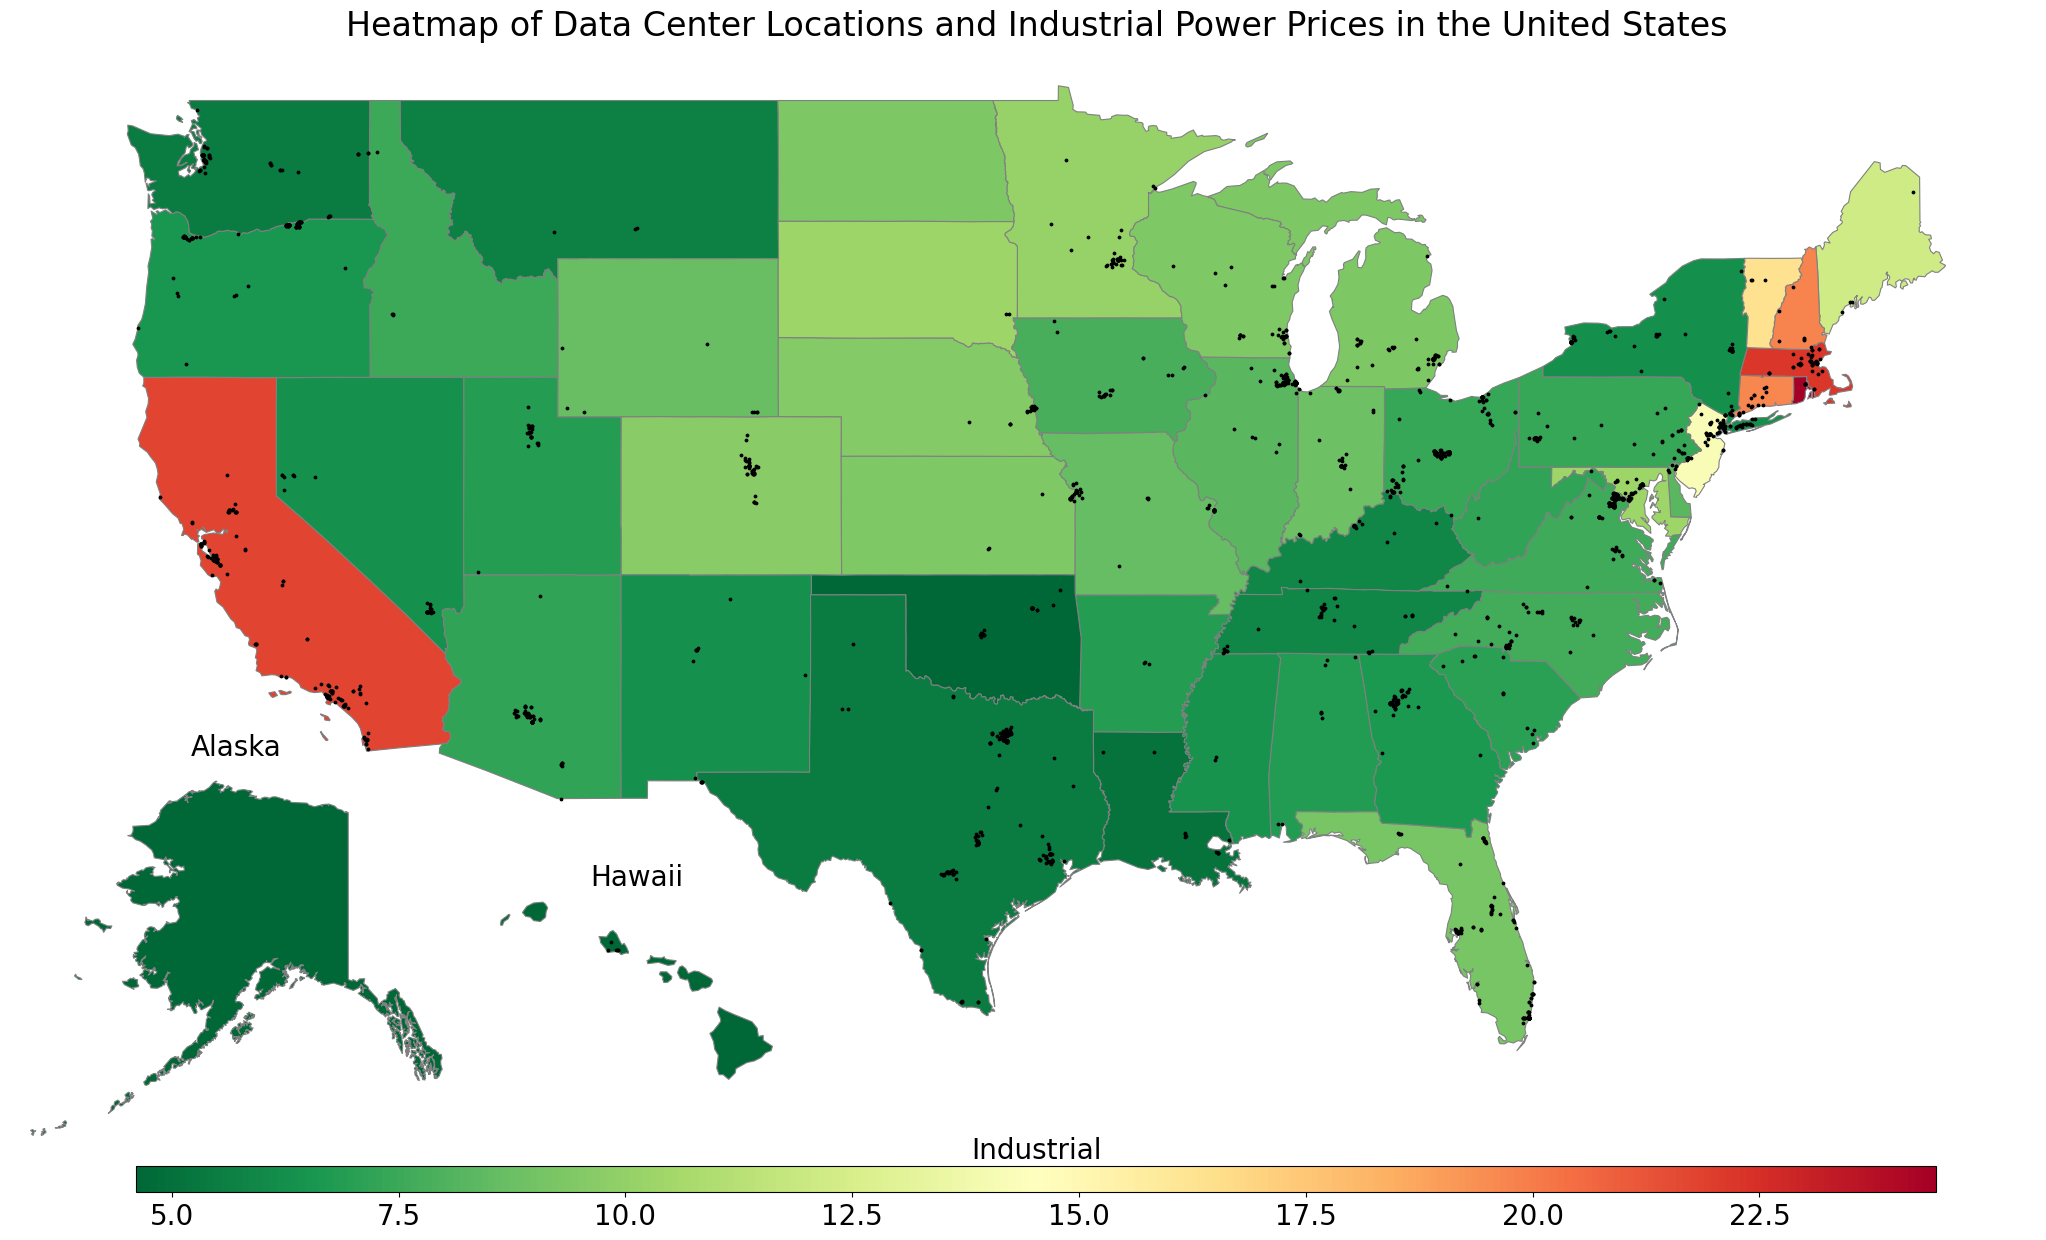

In [277]:
power_sector = 'Industrial'

title = f'Heatmap of Data Center Locations and {power_sector} Power Prices in the United States'

plot_us_states(merged_data, power_sector, plot_points=dc_gdf, title=title, colormap='RdYlGn_r')

In [256]:

print(states_map.columns)
print(dc_df.columns)

Index(['FID', 'Program', 'State_Code', 'State_Name', 'Flowing_St', 'FID_1',
       'geometry'],
      dtype='object')
Index(['name', 'id', 'latitude', 'longitude', 'address', 'city', 'state',
       'country'],
      dtype='object')


In [257]:
def uppercase_df(input_df):
    return input_df.map(lambda x: x.upper() if isinstance(x, str) else x)

In [258]:
state_counts = dc_df['state'].value_counts().reset_index()
# Convert all string values in the dataframe to uppercase since the shapefile uses uppercase state names
state_counts = uppercase_df(state_counts)
state_counts.columns = ['State_Name', 'Datacenter_Count']
state_counts.head()


,State_Name,Datacenter_Count
0,VIRGINIA,311
1,CALIFORNIA,259
2,TEXAS,241
3,OHIO,150
4,NEW YORK,128


In [ ]:
# Merge the state counts with the state shapefile map based on state names
merged_data = merged_data.merge(state_counts, how='left', on='State_Name')

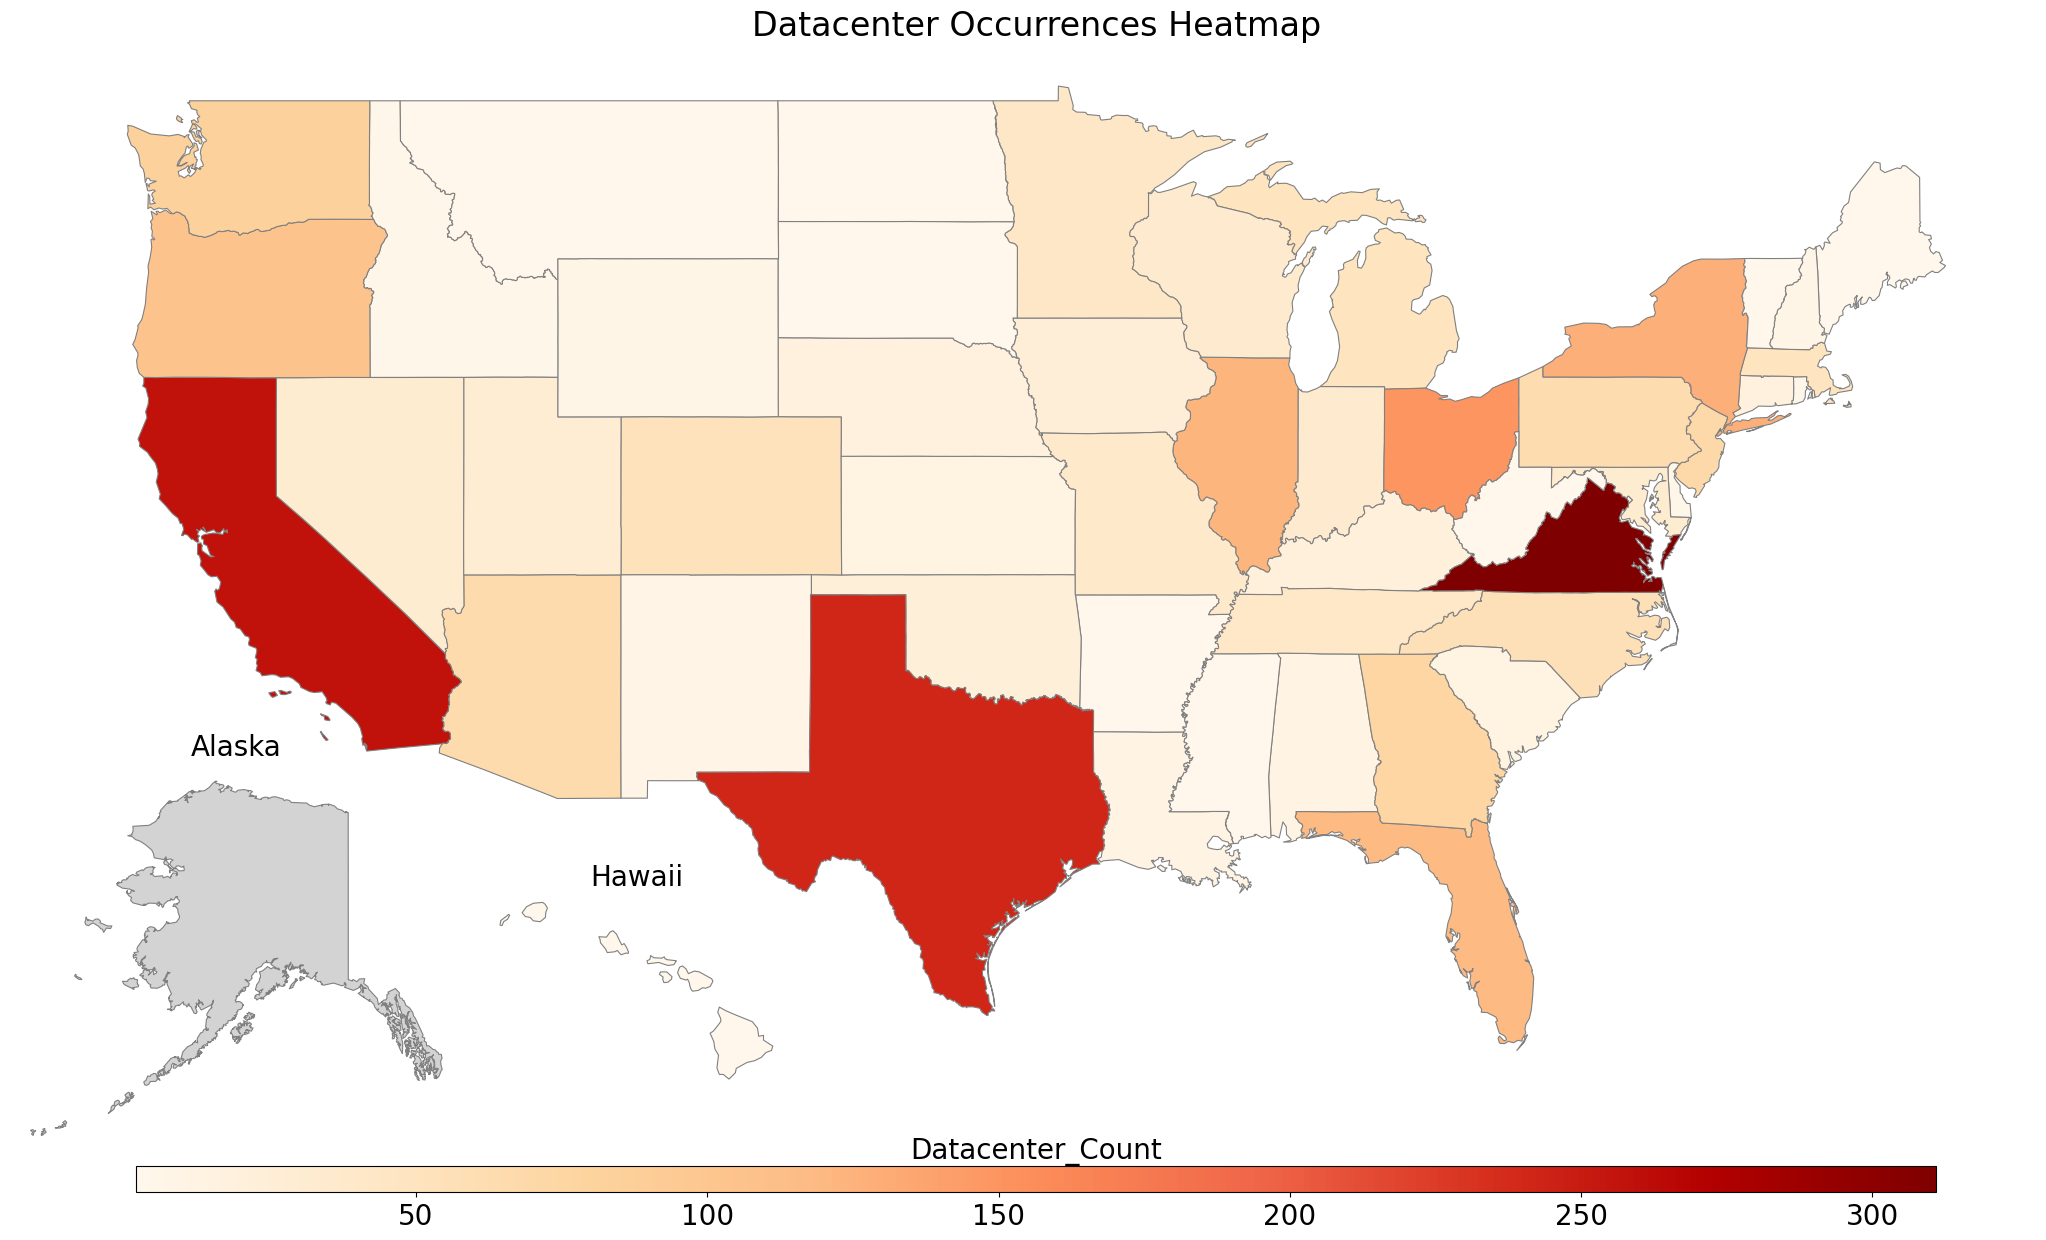

In [278]:
data_column = 'Datacenter_Count'

title = f'Datacenter Occurrences Heatmap'

plot_us_states(merged_data, data_column, title=title, colormap='OrRd')

In [260]:
internet_df = pd.read_csv('../in/average-internet-speed-by-state-2024.csv')

internet_df = uppercase_df(internet_df)

internet_df.rename(columns={'state': 'State_Name'}, inplace=True)

merged_data = merged_data.merge(internet_df, how='left', on='State_Name')

,State_Name,AverageInternetSpeedMbps
0,ALABAMA,344.6
1,ALASKA,285.1
2,ARIZONA,396.1
3,ARKANSAS,230.4
4,CALIFORNIA,93.0


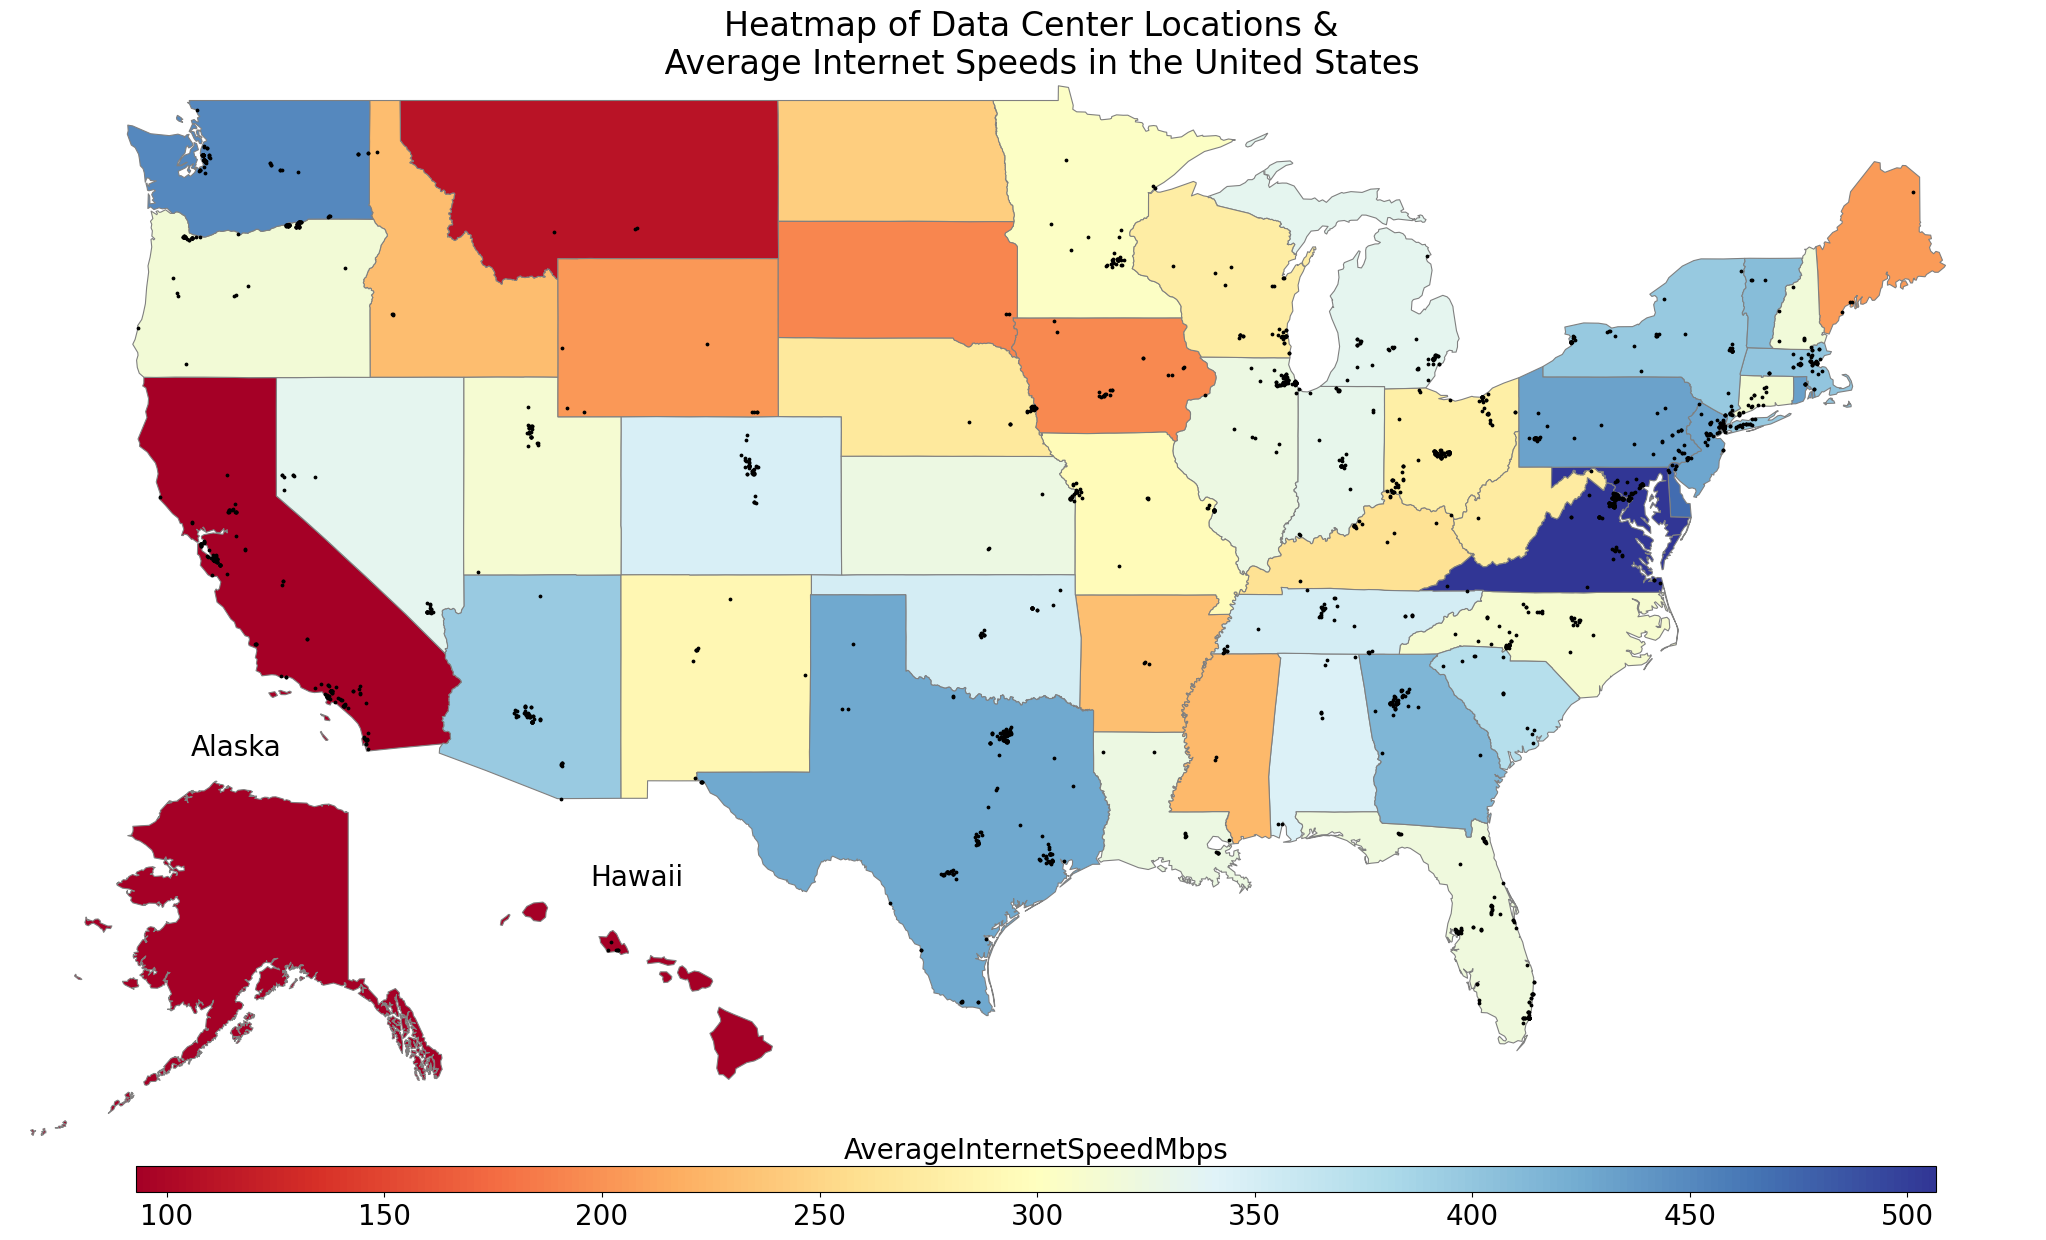

In [262]:
data_column = 'AverageInternetSpeedMbps'

title = f'Heatmap of Data Center Locations & \n Average Internet Speeds in the United States'

plot_us_states(merged_data, data_column, plot_points=dc_gdf, title=title, colormap='RdYlBu')

## State temperatures

First, we import the average annual temperature by states for 2023.

In [266]:
state_temp_file = os.path.join('..','in','state_temp.csv')
state_temp = pd.read_csv(state_temp_file, skiprows=4)
state_temp.head()

,ID,Name,Value,Anomaly (1901-2000 base period),Rank,1901-2000 Mean
0,1,Alabama,65.4,2.3,127,63.1
1,2,Arizona,60.8,1.4,105,59.4
2,3,Arkansas,62.9,2.5,126,60.4
3,4,California,58.2,0.8,92,57.4
4,5,Colorado,45.9,1.3,101,44.6


Then, we rename the "name" colum to "State_Name" and the "value" column to "temperature".

In [267]:
state_temp.rename(columns={'Name' : 'State_Name', 'Value' : 'temperature'}, inplace=True)

state_temp = state_temp[['State_Name','temperature']]

state_temp.head()

,State_Name,temperature
0,Alabama,65.4
1,Arizona,60.8
2,Arkansas,62.9
3,California,58.2
4,Colorado,45.9


Then we convert the temperatures from fahrenheit to celsius by applying a custom funtion to the column.

In [268]:
def fahrenheit_to_celsius(fahrenheit):
    """
    Convert Fahrenheit to Celsius.

    Parameters:
    fahrenheit (float): Temperature in Fahrenheit.

    Returns:
    float: Temperature in Celsius.
    """
    celsius = (fahrenheit - 32) * 5.0/9.0
    return celsius

state_temp['temperature'] = state_temp['temperature'].apply(fahrenheit_to_celsius)

state_temp.head()

,State_Name,temperature
0,Alabama,18.555556
1,Arizona,16.000000
2,Arkansas,17.166667
3,California,14.555556
4,Colorado,7.722222


In [269]:
#converting to uppercase again, because thats what the merged_data shapefile uses for state names.
state_temp = uppercase_df(state_temp)

merged_data = merged_data.merge(state_temp, how='left', on='State_Name')

merged_data.head()


,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,Year,State,Industry Sector Category,Residential,Commercial,Industrial,Transportation,Other,Total,Datacenter_Count,AverageInternetSpeedMbps,temperature
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",2020,AL,Total Electric Industry,12.58,11.55,5.87,0.00,NaN,9.84,11.0,344.6,18.555556
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",2020,AK,Total Electric Industry,22.57,19.58,15.88,0.00,NaN,19.82,NaN,285.1,NaN
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",2020,AZ,Total Electric Industry,12.27,10.11,6.07,9.38,NaN,10.44,66.0,396.1,16.000000
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",2020,AR,Total Electric Industry,10.41,8.61,5.89,13.32,NaN,8.32,3.0,230.4,17.166667
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",2020,CA,Total Electric Industry,20.45,17.53,14.27,10.07,NaN,18.00,259.0,93.0,14.555556


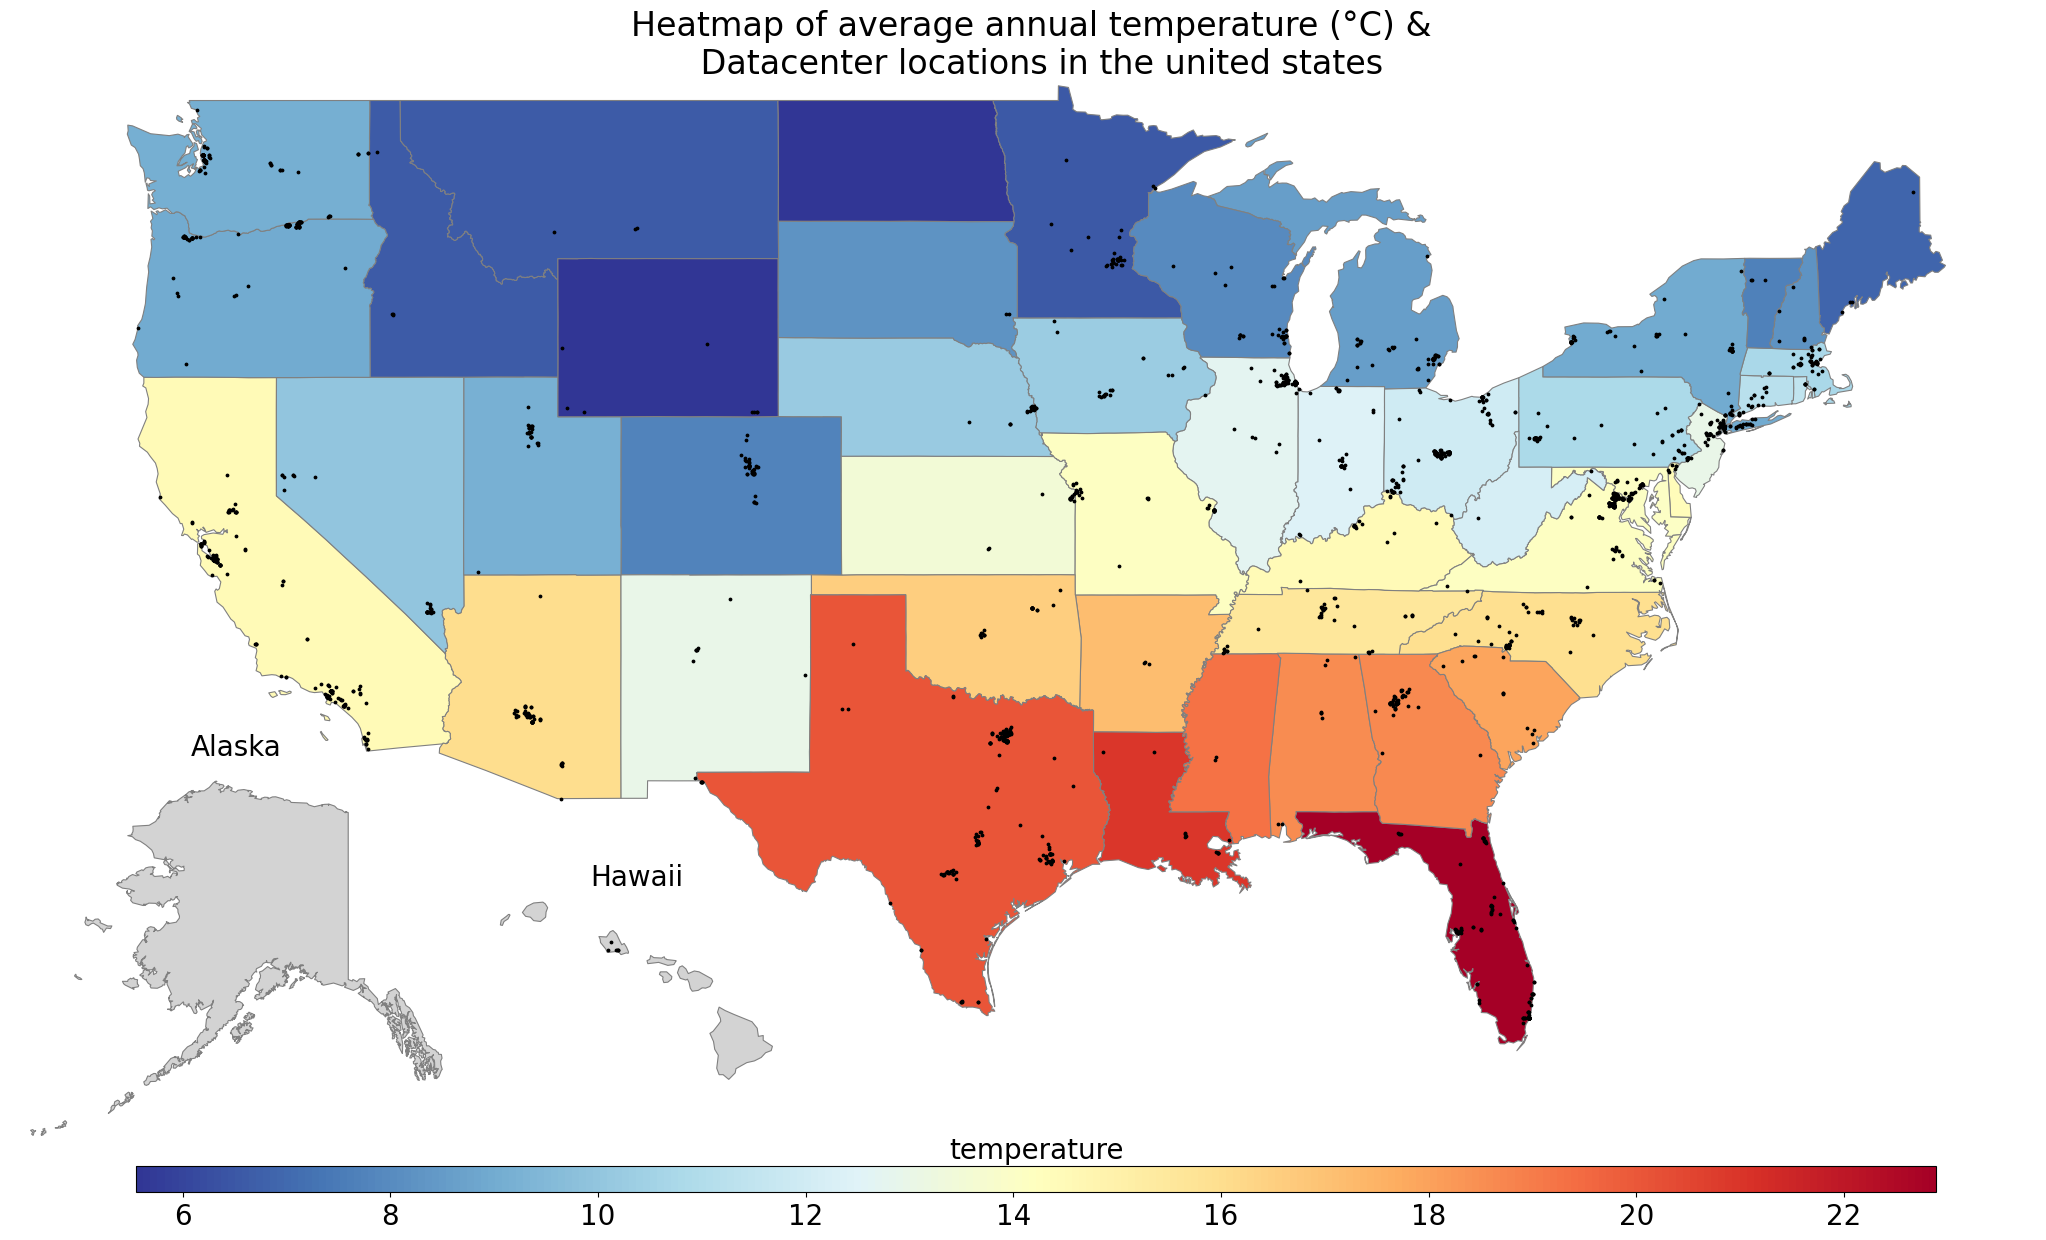

In [270]:
data_column = 'temperature'

title = f'Heatmap of average annual temperature (°C) & \n Datacenter locations in the united states'

plot_us_states(merged_data, data_column, plot_points=dc_gdf, title=title, colormap='RdYlBu_r')

## Humidity

In [271]:
humidity_file = os.path.join('..','in','most-humid-states-2024.csv')
state_humidity = pd.read_csv(humidity_file)
state_humidity.head()

,state,MostHumidStatesAverageRelativeHumidity,MostHumidStatesAverageDewPointF
0,Alabama,71.6,54.0
1,Alaska,77.1,26.5
2,Arizona,38.5,32.5
3,Arkansas,70.9,50.7
4,California,61.0,44.2


Renaming the columns

In [272]:
state_humidity.rename(columns={'state' : 'State_Name',
                               'MostHumidStatesAverageRelativeHumidity' : 'relative_humidity',
                               'MostHumidStatesAverageDewPointF' : 'avg_dewpoint'},
                               inplace=True)
state_humidity.head()

,State_Name,relative_humidity,avg_dewpoint
0,Alabama,71.6,54.0
1,Alaska,77.1,26.5
2,Arizona,38.5,32.5
3,Arkansas,70.9,50.7
4,California,61.0,44.2


Converting State_Name column to uppercase, and converting dewpoint from fahrenheit to celsius

In [273]:
state_humidity = uppercase_df(state_humidity)

state_humidity['avg_dewpoint'] = state_humidity['avg_dewpoint'].apply(fahrenheit_to_celsius)

state_humidity.head()

,State_Name,relative_humidity,avg_dewpoint
0,ALABAMA,71.6,12.222222
1,ALASKA,77.1,-3.055556
2,ARIZONA,38.5,0.277778
3,ARKANSAS,70.9,10.388889
4,CALIFORNIA,61.0,6.777778


In [274]:
merged_data = merged_data.merge(state_humidity, how='left', on='State_Name')

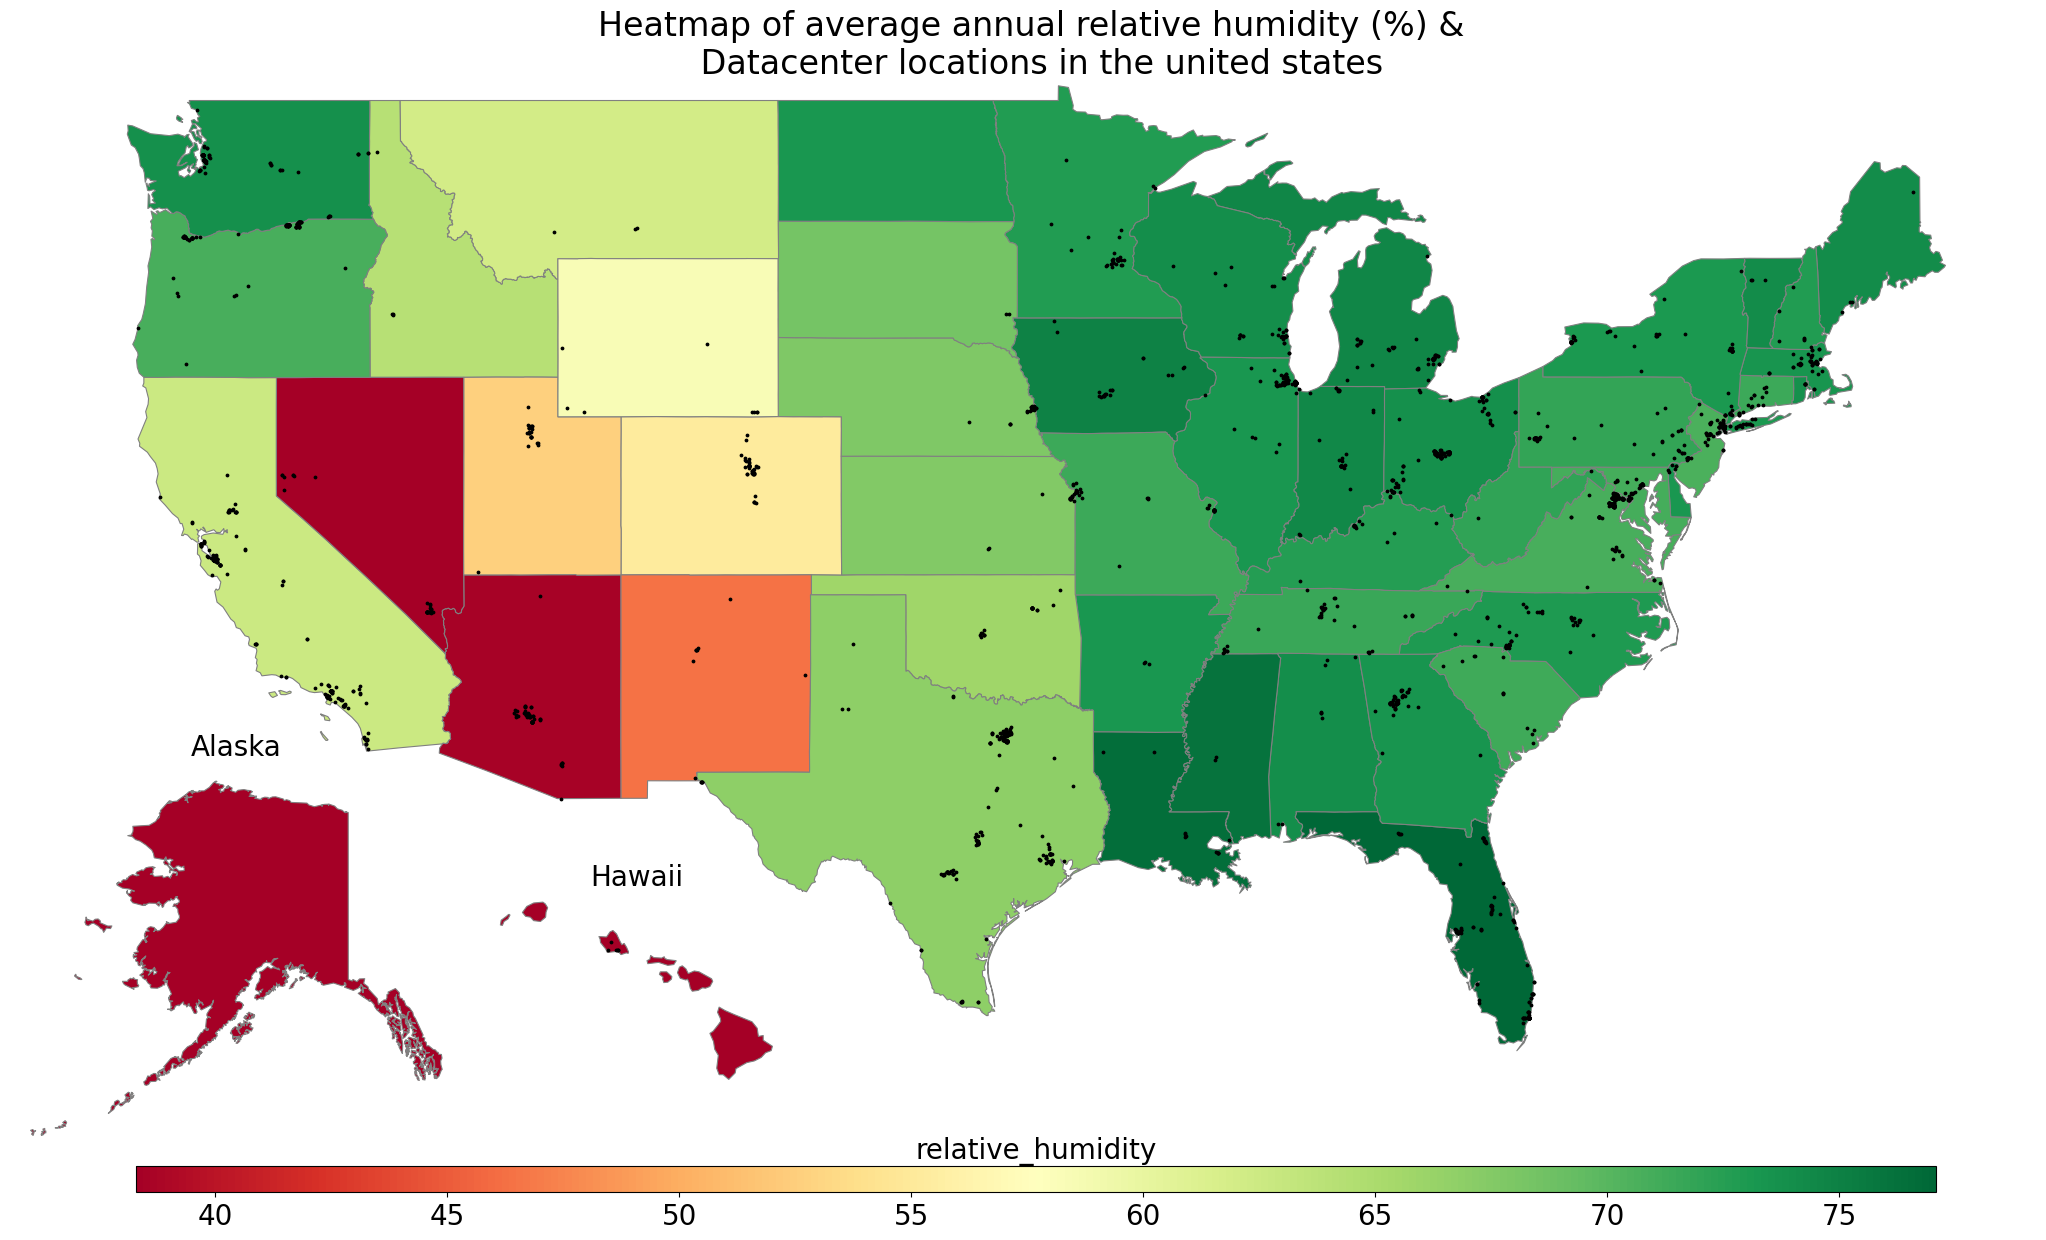

In [279]:
data_column = 'relative_humidity'

title = f'Heatmap of average annual relative humidity (%) & \n Datacenter locations in the united states'

plot_us_states(merged_data, data_column, plot_points=dc_gdf, title=title, colormap='RdYlGn')